# **Deep Neural Network for Image Classification**

### **Introduction**

Welcome to my image classification project, a venture into the realm of binary classification distinguishing between images of cats and non-cats. In this project, I've undertaken the implementation of a deep learning model with specific dimensions, defined as layers_dims = [12288, 20, 7, 5, 1], constituting a four-layer neural network. The primary objective of this endeavor was to manually code all the necessary functions for both forward and backward propagation. By delving into this hands-on approach, I aimed to deepen my understanding of neural network architecture and the intricacies of gradient descent. This project serves as a valuable learning experience, providing insights into the mechanics of a neural network's structure and the optimization processes involved.

In [22]:
import numpy as np
import h5py
import copy
import random
import matplotlib.pyplot as plt
from PIL import Image

### **Dataset**

The data I used is stored in two H5 files: train and test.
- Features (train_set_x and test_set_x): This array contains the features representing images used for training the neural network. 
- Labels (train_set_y and test_set_y): This array contains the corresponding labels for the training images, indicating whether each image belongs to a specific class (e.g., cat or non-cat). The labels are initially stored as a row vector and then reshaped to (1, m), where "m" is the number of training examples.
- Classes (list_classes): This array contains the list of classes used in the dataset. In the context of a binary classification task, it includes labels such as "cat" and "non-cat."

In [5]:
def load_data():
    train_dataset = h5py.File('datasets//train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.
56


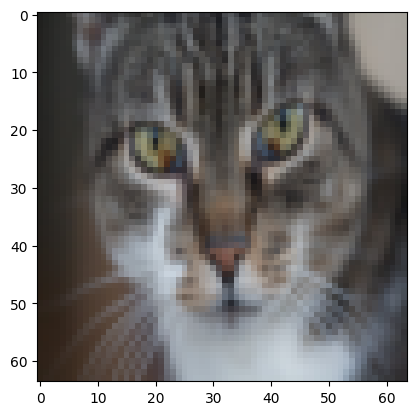

In [7]:
index = random.randint(0,len(train_x_orig))
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")
print(index)

As usual, we reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images\imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.


### **Functions to implement the model**

Firstly, let's define the function that will initialize randomly our parameters.

In [9]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

The neural network will be composed by L layers as following : 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

In [10]:
def relu(z):
    cache = z 
    return np.maximum(0,z), cache

def sigmoid(z):
    cache = z 
    return 1 / (1 + np.exp(-z)), cache


In [11]:
def linear_forward(A_prev, W ,b):
    """ 
    Input :
        - A_prev : activations from the previous layer
        - W : weight parameters
        - b : bias parameters
    
    Output :
        - Z = A_prev * W + b
        - cache : will be useful for backward propagation
    """
    Z = np.dot(W, A_prev) + b 
    cache = (A_prev, W, b)
    return Z, cache

def linear_activations_forward(A_prev, W, b, activation):
 
    """  
    Input :
        - A_prev : activations from the previous layer
        - W : weight parameters
        - b : bias parameters
        - activation : (string) the name of the activation function

    Ouput :
        - activation(Z) and cache
    """

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    if activation == 'relu':
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache 

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Input:
    X : data, numpy array of shape (input size, number of examples)
    parameters : output of initialize_parameters_deep()
    
    Ouput:
    AL : activation value from the output (last) layer
    caches : list of caches containing:
             every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    L = len(parameters) // 2 # number of layers as parameters contains W and b for each layer
    A = X

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activations_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)

    AL, cache =  linear_activations_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches


Cost function formula for sigmoid : 
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [12]:
def cost_function(AL, Y):
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    
    return cost

Let's implement the backward propagation

**Reminder**: 

<img src="images\backprop_kiank.png" style="width:650px;height:250px;">

Here is the chain rule of calculus that can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, we use the previous chain rule and we do $dW^{[1]} = dZ^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step we multiply our current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and we do $db^{[1]} = dZ^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$

In [13]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache 
    s, _ = sigmoid(Z)
    dZ = dA * s * (1 - s) # g' = s * (1 - s)
    return dZ

def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0 # the derivate is 0 for z<=0 and 1 for z > 0
    return dZ

Now, here are the formulas we need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [14]:
def linear_backward(dZ, linear_cache):
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. /m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, caches, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Input:
        dA : post-activation gradient for current layer l 
        cache : tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
        activation : the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Ouput:
        dA_prev : Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW : Gradient of the cost with respect to W (current layer l), same shape as W
        db : Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = caches

    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """

    grads = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer 
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Loop from L-1 to 0 
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [17]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # divided by 2 as paramas contains W and b for each layer

    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]

    return parameters

In [18]:
def predict(X, y, parameters, treshold=0.5):
    probas, _ = L_model_forward(X, parameters)
    p = []
    for i in range(probas.shape[1]):
        p.append(1) if probas[0,i] > treshold else p.append(0)
    
    print("Accuracy: "  + str(np.sum((p == y)/X.shape[1])))
    return p

### **Model implementation**

Now I finished to create all my functions, I can implement the model and test it.

In [19]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 5000, print_cost=True):

    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(num_iterations):
        # Forward propagation
        AL, caches = L_model_forward(X, parameters)
        
        # Compute the cost
        cost = cost_function(AL, Y)
        costs.append(cost)

        # Gradient descent
        grads = L_model_backward(AL, Y, caches) 

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if (i%100 == 0 or i == num_iterations - 1) and print_cost == True:
            print(f'Cost after {i} iteration : {np.squeeze(costs[i])}')
        
    return parameters, costs

parameters, costs = L_layer_model(train_x, train_y, layers_dims)
print()
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Cost after 0 iteration : 0.7717493284237686
Cost after 100 iteration : 0.6720534400822914
Cost after 200 iteration : 0.6482632048575212
Cost after 300 iteration : 0.6115068816101354
Cost after 400 iteration : 0.5670473268366111
Cost after 500 iteration : 0.5401376634547801
Cost after 600 iteration : 0.5279299569455267
Cost after 700 iteration : 0.4654773771766851
Cost after 800 iteration : 0.36912585249592794
Cost after 900 iteration : 0.39174697434805344
Cost after 1000 iteration : 0.31518698886006163
Cost after 1100 iteration : 0.2726998441789385
Cost after 1200 iteration : 0.23741853400268137
Cost after 1300 iteration : 0.19960120532208647
Cost after 1400 iteration : 0.18926300388463305
Cost after 1500 iteration : 0.16118854665827748
Cost after 1600 iteration : 0.14821389662363316
Cost after 1700 iteration : 0.13777487812972944
Cost after 1800 iteration : 0.1297401754919012
Cost after 1900 iteration : 0.12122535068005212
Cost after 2000 iteration : 0.11382060668633712
Cost after 210

The results on accuracy suggest overfitting. Implementing a regularization method like L1 or L2 could be a good idea, or revisiting the diversification of the dataset. Alternatively, reducing the number of iterations might also be considered.

In [20]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, 0.0075, 3000, print_cost=False)
print()
pred_train = predict(train_x, train_y, parameters, )
pred_test = predict(test_x, test_y, parameters)


Accuracy: 0.9904306220095691
Accuracy: 0.8200000000000001


Indeed, reducing the number of iterations to 3000 resulted in an increase in accuracy from 78% to 82%.

Let's try the model on my own cat picture.

Accuracy: 1.0
y = 1, your L-layer model predicts a "cat" picture.


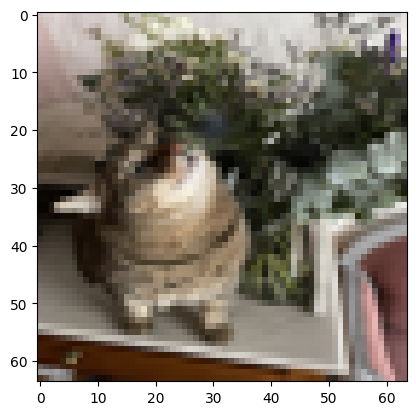

In [24]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

my_image = "chatik.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)


fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")